In [1]:
import pickle 
import pandas as pd
import numpy as np
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn.utils.clip_grad import clip_grad_norm
import torch.optim as optim

from transformer.Modules import LockedDropout, LayerNormalization,Linear
from transformer.Encoder_Decoder import Encoder, Decoder

In [50]:
with open('../data/data_done.pickle','rb') as f:
    train_bunch,val_dict,test_dict,size_dict = pickle.load(f)

In [51]:
size_dict

{'Assortment': (3, 2),
 'DayOfWeek': (7, 4),
 'Id': (41090, 10),
 'Open': (2, 1),
 'Promo': (2, 1),
 'Sales': (20028, 10),
 'SchoolHoliday': (2, 1),
 'StateHoliday': (4, 2),
 'Store': (856, 10),
 'StoreType': (4, 2),
 'dom': (31, 10),
 'doy': (365, 10),
 'month': (12, 6),
 'quarter': (4, 2),
 'week': (52, 10)}

In [52]:
embed_keys = ['Assortment','DayOfWeek','StateHoliday',
             'Store','StoreType','dom','doy','month','quarter','week']
linear_keys = ['Open','Promo','SchoolHoliday']

In [53]:
class Transformer(nn.Module):
    def __init__(self,d_model,d_pos,edrop,odrop,size_dict=size_dict,lookback=112,future=48):
        super(Transformer,self).__init__()
        
        self.Assortment_embed = nn.Embedding(size_dict['Assortment'][0],size_dict['Assortment'][1])
        self.DayOfWeek_embed = nn.Embedding(size_dict['DayOfWeek'][0],size_dict['DayOfWeek'][1])
        self.StateHoliday_embed = nn.Embedding(size_dict['StateHoliday'][0],size_dict['StateHoliday'][1])
        self.Store_embed = nn.Embedding(size_dict['Store'][0],size_dict['Store'][1])
        self.StoreType_embed = nn.Embedding(size_dict['StoreType'][0],size_dict['StoreType'][1])
        self.dom_embed = nn.Embedding(size_dict['dom'][0],size_dict['dom'][1])
        self.doy_embed = nn.Embedding(size_dict['doy'][0],size_dict['doy'][1])
        self.month_embed = nn.Embedding(size_dict['month'][0],size_dict['month'][1])
        self.quarter_embed = nn.Embedding(size_dict['quarter'][0],size_dict['quarter'][0])
        self.week_embed = nn.Embedding(size_dict['week'][0],size_dict['week'][1])
        
        self.sentence_len = lookback+future
        self.Open = Linear(self.sentence_len,self.sentence_len)
        self.Promo = Linear(self.sentence_len,self.sentence_len)
        self.SchoolHoliday = Linear(self.sentence_len,self.sentence_len)
        self.Sales = Linear(lookback,lookback)
        
        self.input_length = 64
        #print(self.input_length)
        self.odrop = odrop
        self.Encoder = Encoder(n_max_seq=self.sentence_len,d_model=d_model,d_pos=d_pos)
        self.Decoder = Decoder(n_max_seq=self.sentence_len,d_model=d_model,d_pos=d_pos)
        self.hidden_size = d_model
        self.encoder_mapping = nn.Linear(self.input_length,d_pos)
        self.decoder_mapping = nn.Linear(self.input_length-1,d_pos)
        
        self.output_network = nn.Sequential(
            nn.Linear(self.hidden_size,self.hidden_size),
            nn.ReLU(),
            LayerNormalization(self.hidden_size),
            nn.Linear(self.hidden_size,1)
        )
        self.init_linear_weights()
        
    def init_linear_weights(self):
        #super(Transformer,self).init_weights()
        nn.init.orthogonal(self.encoder_mapping.weight)
        nn.init.constant(self.encoder_mapping.bias,0)
        nn.init.orthogonal(self.decoder_mapping.weight)
        nn.init.constant(self.decoder_mapping.bias,0)
        for submodel in (self.Encoder,self.Decoder):
            for m in submodel.parameters():
                if isinstance(m,(nn.Linear,nn.Conv1d)):
                    nn.init.orthogonal(m.weight)
                    nn.init.constant(m.bias,0)
        for m in self.output_network:
            if isinstance(m,nn.Linear):
                nn.init.orthogonal(m.weight)
                nn.init.constant(m.bias,0)
    
    def get_trainable_parameters(self): #applied when training
        enc_freezed_param_ids = set(map(id,self.Encoder.position_enc.parameters()))
        dec_freezed_param_ids = set(map(id,self.Decoder.position_enc.parameters()))
        freezed_param_ids = enc_freezed_param_ids | dec_freezed_param_ids
        return (p for p in self.parameters() if id(p) not in freezed_param_ids)
    
    def preprocess_x(self,inputs):
        embeddings = torch.cat([
            self.Assortment_embed(inputs['Assortment']),
            self.DayOfWeek_embed(inputs['DayOfWeek']),
            self.StateHoliday_embed(inputs['StateHoliday']),
            self.Store_embed(inputs['Store']),
            self.StoreType_embed(inputs['StoreType']),
            self.dom_embed(inputs['dom']),
            self.doy_embed(inputs['doy']),
            self.month_embed(inputs['month']),
            self.quarter_embed(inputs['quarter']),
            self.week_embed(inputs['week'])
        ],dim=2)
        dense = torch.cat([
            self.Open(inputs['Open']).unsqueeze(2),
            self.Promo(inputs['Promo']).unsqueeze(2),
            self.SchoolHoliday(inputs['SchoolHoliday']).unsqueeze(2),
        ],2)
        x_encode = torch.cat([
            self.Sales(inputs['Sales'][:,:-48]).unsqueeze(2),
            embeddings[:,:-48,:],dense[:,:-48,:]],2)
        x_decode = torch.cat([embeddings[:,-48:,:],dense[:,-48:,:]],2)
        return x_encode,x_decode
    
    def forward(self,inputs):
        x_encode,x_decode = self.preprocess_x(inputs)
        enc_pos = Variable(torch.arange(0,x_encode.size()[1]).long())
        dec_pos = Variable(torch.arange(0,x_decode.size()[1]).long())
        #print(x_decode.size(),x_encode.size(),self.input_length)
        x_encode = self.encoder_mapping(x_encode)
        #print(x_encode.size())
        #enc_output,*_ = self.Encoder(x_encode,enc_pos)
        enc_output = self.Encoder(x_encode,enc_pos)
        '''
        step_one = self.step_one_network(
            F.dropout(enc_output,self.odrop)
        ).squeeze(2)
        '''
        #[:,-1,:]
        #print(enc_output.size())
        x_decode = self.decoder_mapping(x_decode)
        #dec_output,*_ = self.Decoder(x_decode,dec_pos,x_encode,enc_output)
        dec_output = self.Decoder(x_decode,dec_pos,x_encode,enc_output)
        reg_output = self.output_network(
            F.dropout(dec_output,self.odrop)
        ).squeeze(2)
        #print('reg_output dim',reg_output.size())
        return reg_output

In [58]:
transformer = Transformer(d_model=128,d_pos=128,edrop=0.1,odrop=0.1)
print(transformer)

Transformer(
  (Assortment_embed): Embedding(3, 2)
  (DayOfWeek_embed): Embedding(7, 4)
  (StateHoliday_embed): Embedding(4, 2)
  (Store_embed): Embedding(856, 10)
  (StoreType_embed): Embedding(4, 2)
  (dom_embed): Embedding(31, 10)
  (doy_embed): Embedding(365, 10)
  (month_embed): Embedding(12, 6)
  (quarter_embed): Embedding(4, 4)
  (week_embed): Embedding(52, 10)
  (Open): Linear(
    (linear): Linear(in_features=160, out_features=160)
  )
  (Promo): Linear(
    (linear): Linear(in_features=160, out_features=160)
  )
  (SchoolHoliday): Linear(
    (linear): Linear(in_features=160, out_features=160)
  )
  (Sales): Linear(
    (linear): Linear(in_features=112, out_features=112)
  )
  (Encoder): Encoder(
    (position_enc): Embedding(161, 128, padding_idx=0)
    (layer_stack): ModuleList(
      (0): EncoderLayer(
        (slf_attn): MultiHeadAttention(
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1)
            (softmax): BottleSoftmax()
      

In [65]:
train_loss = []
loss_func = F.mse_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.01
}]
optimizer = optim.SGD(param_groups,momentum=0.95,nesterov=True)
for epoch in range(10):
    for t in train_bunch:
        for start_i in range(0,856,128):
            end_i = start_i + 128
            train_dict = {i:None for i in linear_keys+embed_keys+['Sales']}
            for k in train_dict.keys():
                if k in ['Sales','Open','Promo','SchoolHoliday']:
                    train_dict[k] = Variable(torch.FloatTensor(t[k].iloc[start_i:end_i].values))
                else:
                    train_dict[k] = Variable(torch.LongTensor(t[k].iloc[start_i:end_i].values))
            output = transformer(train_dict)
            batch_loss = loss_func(output,train_dict['Sales'][:,-48:])
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print(batch_loss.data[0])
            clip_grad_norm(transformer.parameters(),5)
            optimizer.step()

torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])


/home/lehas-ai/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py:357: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = self.forward(*input, **kwargs)


encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output s

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.S

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 1

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.S

k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])


encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([12

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([12

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size:

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128])

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output s

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.S

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128]

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.

k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: to

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.S

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([12

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: t

reg_output dim torch.Size([88, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fina

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: to

encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Si

encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
final encoder enc_output size: torch.Size([128, 112, 128])
torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]

reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
fin

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 64
torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([128, 112, 128])
encoder enc_output size: torch.Size([128, 112, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 112, 128]) v: torch.Size([

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([88, 48, 63]) torch.Size([88, 112, 64]) 64
torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Siz

k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
k: torch.Size([128, 48, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 48, 128])
k: torch.Size([128, 112, 128]) q: torch.Size([128, 48, 128]) v: torch.Size([128, 112, 128])
reg_output dim torch.Size([128, 48])
torch.Size([128, 48, 63]) torch.Size([128, 112, 64]) 

encoder enc_output size: torch.Size([88, 112, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 112, 128]) v: torch.Size([88, 112, 128])
encoder enc_output size: torch.Size([88, 112, 128])
final encoder enc_output size: torch.Size([88, 112, 128])
torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88, 48, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 48, 128])
k: torch.Size([88, 112, 128]) q: torch.Size([88, 48, 128]) v: torch.Size([88, 112, 128])
k: torch.Size([88

In [67]:
batch_loss[-1]

Variable containing:
 12.4058
[torch.FloatTensor of size 1]

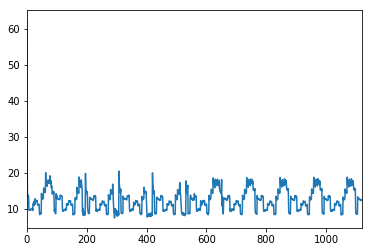

In [73]:
pd.Series(train_loss).plot();

In [71]:
batch_loss.detach().numpy()

array([12.405828], dtype=float32)

In [7]:
train_loss = []
loss_func = F.mse_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(10):
    for t in train_bunch:
        for start_i in range(0,856,128):
            end_i = start_i + 128
            train_dict = {i:None for i in linear_keys+embed_keys+['Sales']}
            for k in train_dict.keys():
                if k in ['Sales','Open','Promo','SchoolHoliday']:
                    train_dict[k] = Variable(torch.FloatTensor(t[k].iloc[start_i:end_i].values))
                else:
                    train_dict[k] = Variable(torch.LongTensor(t[k].iloc[start_i:end_i].values))
            output = transformer(train_dict)
            batch_loss = loss_func(output,train_dict['Sales'][:,-48:])
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print(epoch,batch_loss.data[0])
            clip_grad_norm(transformer.parameters(),5)
            optimizer.step()

0 76.42112731933594
0 13.208319664001465
0 17.60292625427246
0 13.273735046386719
0 13.694001197814941
0 13.293242454528809
0 13.36396312713623
0 9.793976783752441
0 9.230034828186035
0 9.804208755493164
0 9.399835586547852
0 9.390990257263184
0 9.381397247314453
0 9.627243041992188
0 9.751778602600098
0 9.44984245300293
0 9.74988079071045
0 9.671106338500977
0 9.845324516296387
0 9.563309669494629
0 9.60588264465332
0 11.304496765136719
0 10.967534065246582
0 11.223316192626953
0 10.94237232208252
0 11.141030311584473
0 11.086390495300293
0 11.15963077545166
0 12.0864896774292
0 11.87648868560791
0 12.042414665222168
0 11.9010648727417
0 11.84973430633545
0 11.95445728302002
0 12.012606620788574
0 11.20750904083252
0 10.732621192932129
0 10.912795066833496
0 10.883460998535156
0 10.78756332397461
0 11.186593055725098
0 10.890707969665527
0 8.91726016998291
0 8.467440605163574
0 8.60423469543457
0 8.395062446594238
0 8.443610191345215
0 8.809126853942871
0 8.56856632232666
0 13.1738195

KeyboardInterrupt: 

In [7]:
train_loss = []
loss_func = F.mse_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.008
}]
optimizer = optim.Adam(param_groups)
for epoch in range(10):
    for t in train_bunch:
        for start_i in range(0,856,128):
            end_i = start_i + 128
            train_dict = {i:None for i in linear_keys+embed_keys+['Sales']}
            for k in train_dict.keys():
                if k in ['Sales','Open','Promo','SchoolHoliday']:
                    train_dict[k] = Variable(torch.FloatTensor(t[k].iloc[start_i:end_i].values))
                else:
                    train_dict[k] = Variable(torch.LongTensor(t[k].iloc[start_i:end_i].values))
            output = transformer(train_dict)
            batch_loss = loss_func(output,train_dict['Sales'][:,-48:])
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print(epoch,batch_loss.data[0])
            clip_grad_norm(transformer.parameters(),5)
            optimizer.step()

0 52.88444137573242
0 13.703911781311035
0 36.4443244934082
0 17.663818359375
0 14.595481872558594
0 13.39361572265625
0 13.380995750427246
0 9.641444206237793
0 9.21884822845459
0 9.664106369018555
0 9.213418006896973
0 9.405194282531738
0 9.318514823913574
0 9.471189498901367
0 9.75762939453125
0 9.448090553283691
0 9.718422889709473
0 9.587409019470215
0 9.818285942077637
0 9.553398132324219
0 9.503786087036133
0 11.37444019317627
0 10.9717435836792
0 11.276274681091309
0 10.953824043273926
0 11.154755592346191
0 11.113192558288574
0 11.155556678771973
0 12.090198516845703
0 11.902583122253418
0 12.041339874267578
0 11.900044441223145
0 11.863555908203125
0 11.960928916931152
0 12.015469551086426
0 11.210163116455078
0 10.72896671295166
0 10.912697792053223
0 10.896671295166016
0 10.786263465881348
0 11.186396598815918
0 10.90819263458252
0 8.90771770477295
0 8.425521850585938
0 8.580081939697266
0 8.432988166809082
0 8.482650756835938
0 8.831775665283203
0 8.570677757263184
0 13.14

KeyboardInterrupt: 

In [ ]:
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.005
}]
optimizer = optim.Adam(param_groups)
for epoch in range(10):
    for t in train_bunch:
        for start_i in range(0,856,128):
            end_i = start_i + 128
            train_dict = {i:None for i in linear_keys+embed_keys+['Sales']}
            for k in train_dict.keys():
                if k in ['Sales','Open','Promo','SchoolHoliday']:
                    train_dict[k] = Variable(torch.FloatTensor(t[k].iloc[start_i:end_i].values))
                else:
                    train_dict[k] = Variable(torch.LongTensor(t[k].iloc[start_i:end_i].values))
            output = transformer(train_dict)
            batch_loss = loss_func(output,train_dict['Sales'][:,-48:])
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print(epoch,batch_loss.data[0])
            clip_grad_norm(transformer.parameters(),5)
            optimizer.step()

0 6.65533447265625
0 2.367041826248169
0 2.3763678073883057
0 2.8191473484039307
0 2.444007635116577
0 2.1648004055023193
0 2.183685779571533
0 1.5301433801651
0 1.5548481941223145
0 1.5477296113967896
0 1.5412697792053223
0 1.5106706619262695
0 1.5186766386032104
0 1.5465610027313232
0 1.5381741523742676
0 1.5355390310287476
0 1.5746694803237915
0 1.545197606086731
0 1.585568904876709
0 1.5587531328201294
0 1.5489239692687988
0 1.785010814666748
0 1.7605271339416504
0 1.8116817474365234
0 1.7661681175231934
0 1.783637523651123
0 1.7921833992004395
0 1.8033442497253418
0 1.937592625617981
0 1.8867655992507935
0 1.9260245561599731
0 1.9463037252426147
0 1.918251395225525
0 1.9152637720108032
0 1.9192519187927246
0 1.7808114290237427
0 1.727199673652649
0 1.7511218786239624
0 1.7493234872817993
0 1.73603093624115
0 1.8037867546081543
0 1.7353304624557495
0 1.3622418642044067
0 1.3327399492263794
0 1.37775456905365
0 1.3511630296707153
0 1.3462454080581665
0 1.3867491483688354
0 1.3687913

In [60]:
train_loss = []
loss_func = F.l1_loss
param_groups = [{
    'params':transformer.get_trainable_parameters(),'lr':0.005
}]
optimizer = optim.Adam(param_groups)
for epoch in range(10):
    for t in train_bunch:
        for start_i in range(0,856,128):
            end_i = start_i + 128
            train_dict = {i:None for i in linear_keys+embed_keys+['Sales']}
            for k in train_dict.keys():
                if k in ['Sales','Open','Promo','SchoolHoliday']:
                    train_dict[k] = Variable(torch.FloatTensor(t[k].iloc[start_i:end_i].values))
                else:
                    train_dict[k] = Variable(torch.LongTensor(t[k].iloc[start_i:end_i].values))
            output = transformer(train_dict)
            batch_loss = loss_func(output,Variable(train_dict['Sales'][:,-48:].detach().numpy(),requires_grad=False))
            optimizer.zero_grad()
            batch_loss.backward()
            train_loss.append(batch_loss.data[0])
            print(epoch,batch_loss.data[0])
            clip_grad_norm(transformer.parameters(),5)
            optimizer.step()

RuntimeError: Variable data has to be a tensor, but got numpy.ndarray